## Домашнее задание 2
### Выполнил: 
    -> Башаров Илья Валерьевич
    -> ilya.basharov.98@mail.ru

In [1]:
from stats import (
    player_per_team,
    questions_per_tournament,
    percentage_correct_per_tournament,
    percentage_correct_per_team,
)

from dataset import (
    read_dataset,
    preprocess,
    train_test_split,
    question_rating_calc,
)

from features import (
    create_train_matrix_baseline,
    create_test_prediction,
)

from models import (
    EM,
)

from datetime import (
    datetime,
    timedelta,
)

import numpy   as np
import pickle  as pk
import pandas  as pd
import scipy   as sp

import matplotlib.pyplot as plt
%matplotlib notebook

np.random.seed(0)

##### 1.1 Прочитаем данные, выбрав турниры, в которых есть данные о составах команд и повопросных результатах.

In [ ]:
%%bash

wget -q https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip -O chgk.zip

In [2]:
date_start_train = datetime.strptime('2019-01-01', '%Y-%m-%d')
date_start_val = datetime.strptime('2020-01-01', '%Y-%m-%d')

all_data, players, tour_name = preprocess(
    read_dataset('chgk.zip'),
    date_start_train,
)

##### 1.2 Проанализируем данные.

<IPython.core.display.Javascript object>


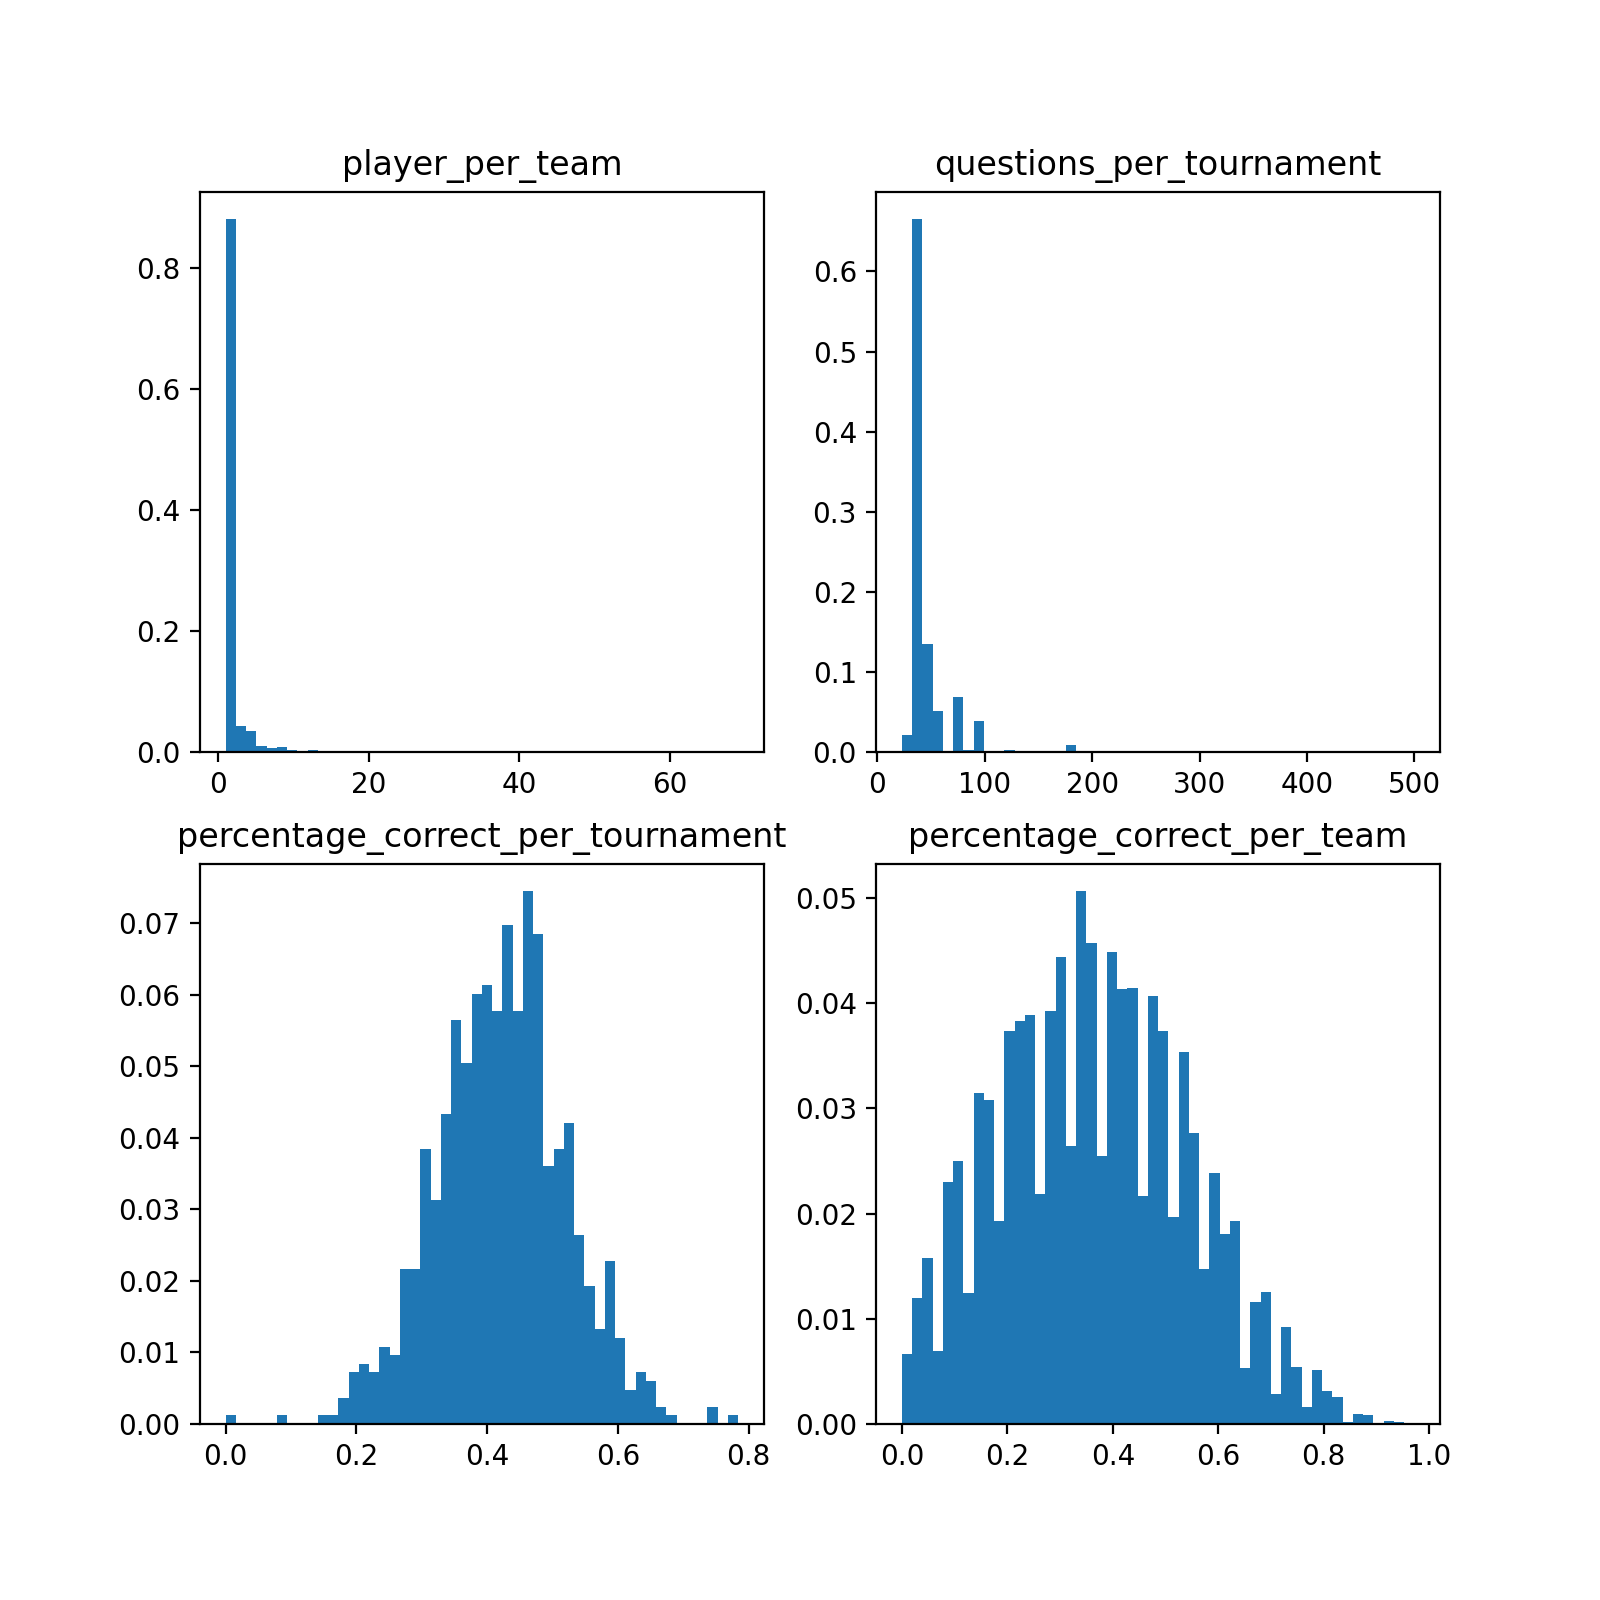

In [3]:
fig, axes2d = plt.subplots(2, 2, figsize=(8, 8))
axes = axes2d.flatten()

for i, aggregation in enumerate((
    player_per_team,
    questions_per_tournament,
    percentage_correct_per_tournament,
    percentage_correct_per_team)):
    
    dist = aggregation(all_data)
    w    = [1/len(dist)]*len(dist)
    
    axes[i].hist(dist.values(), weights=w, bins=50);
    axes[i].set_title(aggregation.__name__);

##### 1.3 Поделим данные на train, test

In [4]:
train, test = train_test_split(all_data, date_start_train, date_start_val)

##### 2.1 Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков.
Алгоритм создания матрицы признаков для линейной регрессии:

```python
feature_matrix = []
for tournament in tournaments:
    for question in questions:
        for member in team:
            feature = [one_hot(member), one_hot(question)]
            feature_matrix.append(feature)
```

In [5]:
X, y, player_to_idx = create_train_matrix_baseline(train, n_team=3)

In [6]:
from sklearn.linear_model import (
    LogisticRegression,
)

lr = LogisticRegression(tol=1e-2, solver='saga', C=1, n_jobs=-1, max_iter=1e2)
lr.fit(X, y);

In [7]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)

pred = lr.predict(X)
for metric_function in (accuracy_score, precision_score, recall_score):
    print(metric_function.__name__, 'at trainset: %.3f' % metric_function(y, pred))

accuracy_score at trainset: 0.766
precision_score at trainset: 0.764
recall_score at trainset: 0.766


##### 3.1 Предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд

<IPython.core.display.Javascript object>


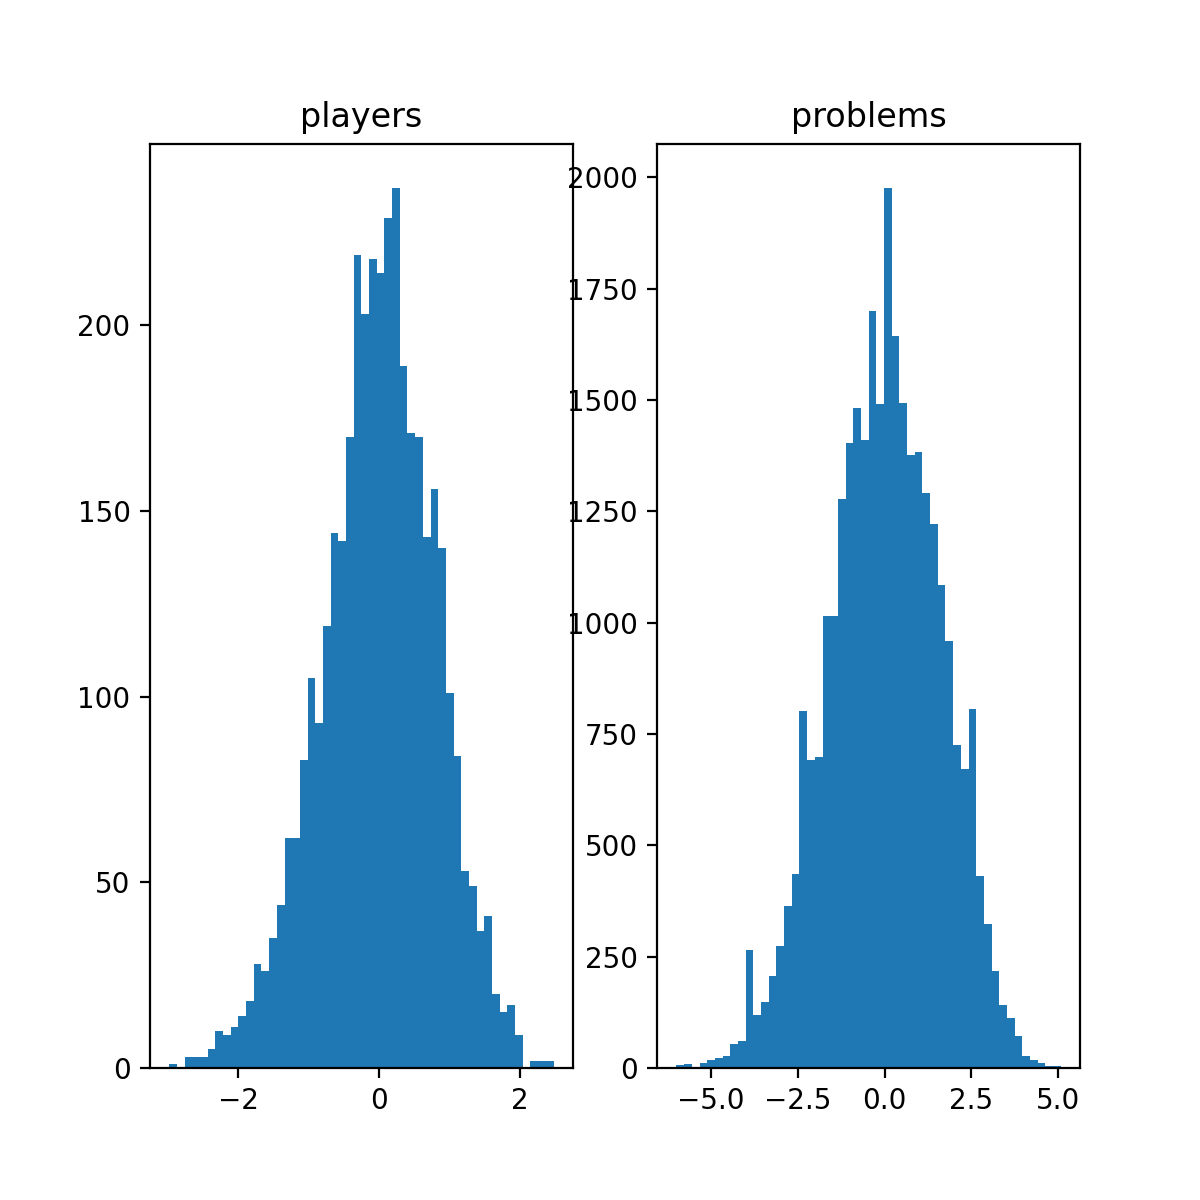

In [8]:
players_ranking = lr.coef_[0, :len(player_to_idx)]
problem_ranking = lr.coef_[0, len(player_to_idx):]

fig, axes1d = plt.subplots(1, 2, figsize=(6, 6))

for i, (ranking, ranking_name) in enumerate(zip(
    (players_ranking, problem_ranking),
    ('players', 'problems'))):
    axes1d[i].hist(ranking, bins=50);
    axes1d[i].set_title(ranking_name);

In [9]:
qv_rating = question_rating_calc(tour_name, problem_ranking, train)

Топ самых сложных турниров

In [10]:
qv_rating.head(20)

,id,name
0,6149,Чемпионат Санкт-Петербурга. Первая лига
1,5928,Угрюмый Ёрш
2,5684,Синхрон высшей лиги Москвы
3,5159,Первенство правого полушария
4,6101,Воображаемый музей
5,5587,Записки охотника
6,5025,Кубок городов
7,5693,Знание – Сила VI
8,5083,Ускользающая сова
9,5943,Чемпионат Мира. Этап 2 Группа С


Топ самых легких турниров

In [11]:
qv_rating.tail(20)

,id,name
643,5967,ОЧВР. 3 тур
644,5511,KFC
645,5728,Синхрон-lite. Выпуск XXIX
646,5130,Лига Сибири. VI тур.
647,5697,Школьный Синхрон-lite. Выпуск 3.1
648,5855,Лига вузов. IV тур
649,5704,(а)Синхрон-lite. Лига старта. Эпизод X
650,5729,Синхрон-lite. Выпуск XXX
651,5954,Школьная лига. II тур.
652,5008,Школьный Синхрон-lite. Выпуск 2.3


Видно, что 'сила' вопросов имеет экспоненциальное распроделение c центром в 0. В качестве вопроса для предсказания возьмем вопрос с весом w = 0. Поскольку $y = \sigma(\sum_{i}w_{i}x_{i})) = \sigma(\underbrace{\sum_{i}w_{i}x_{i}}_{players} + \underbrace{\sum_{j}w_{j}x_{j}}_{questions = 0})) = \sigma(\sum_{i}w_{i}x_{i})$

В качестве рейтинга будем использовать $\mathbb{P}(team = 1) = 1 - \prod_{player \in team}\mathbb{P}(player = 0)$, используя предположение о независимом голосовании (не учитывая, по сути, влияние 'силы' игрока, так как в жизни часто доверяют более 'сильным')

In [12]:
rating_pred, rating_gt = create_test_prediction(
    dataset=test,
    player_to_idx=player_to_idx,
    model=lr,
    n_features=X.shape[1],
)

##### 3.2 В качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете scipy) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров

In [13]:
spearman = [
    sp.stats.spearmanr(rating_gt[i], rating_pred[i]).correlation
    for i in range(len(rating_pred))
]

kendall = [
    sp.stats.kendalltau(rating_gt[i], rating_pred[i]).correlation
    for i in range(len(rating_pred))
]

<IPython.core.display.Javascript object>


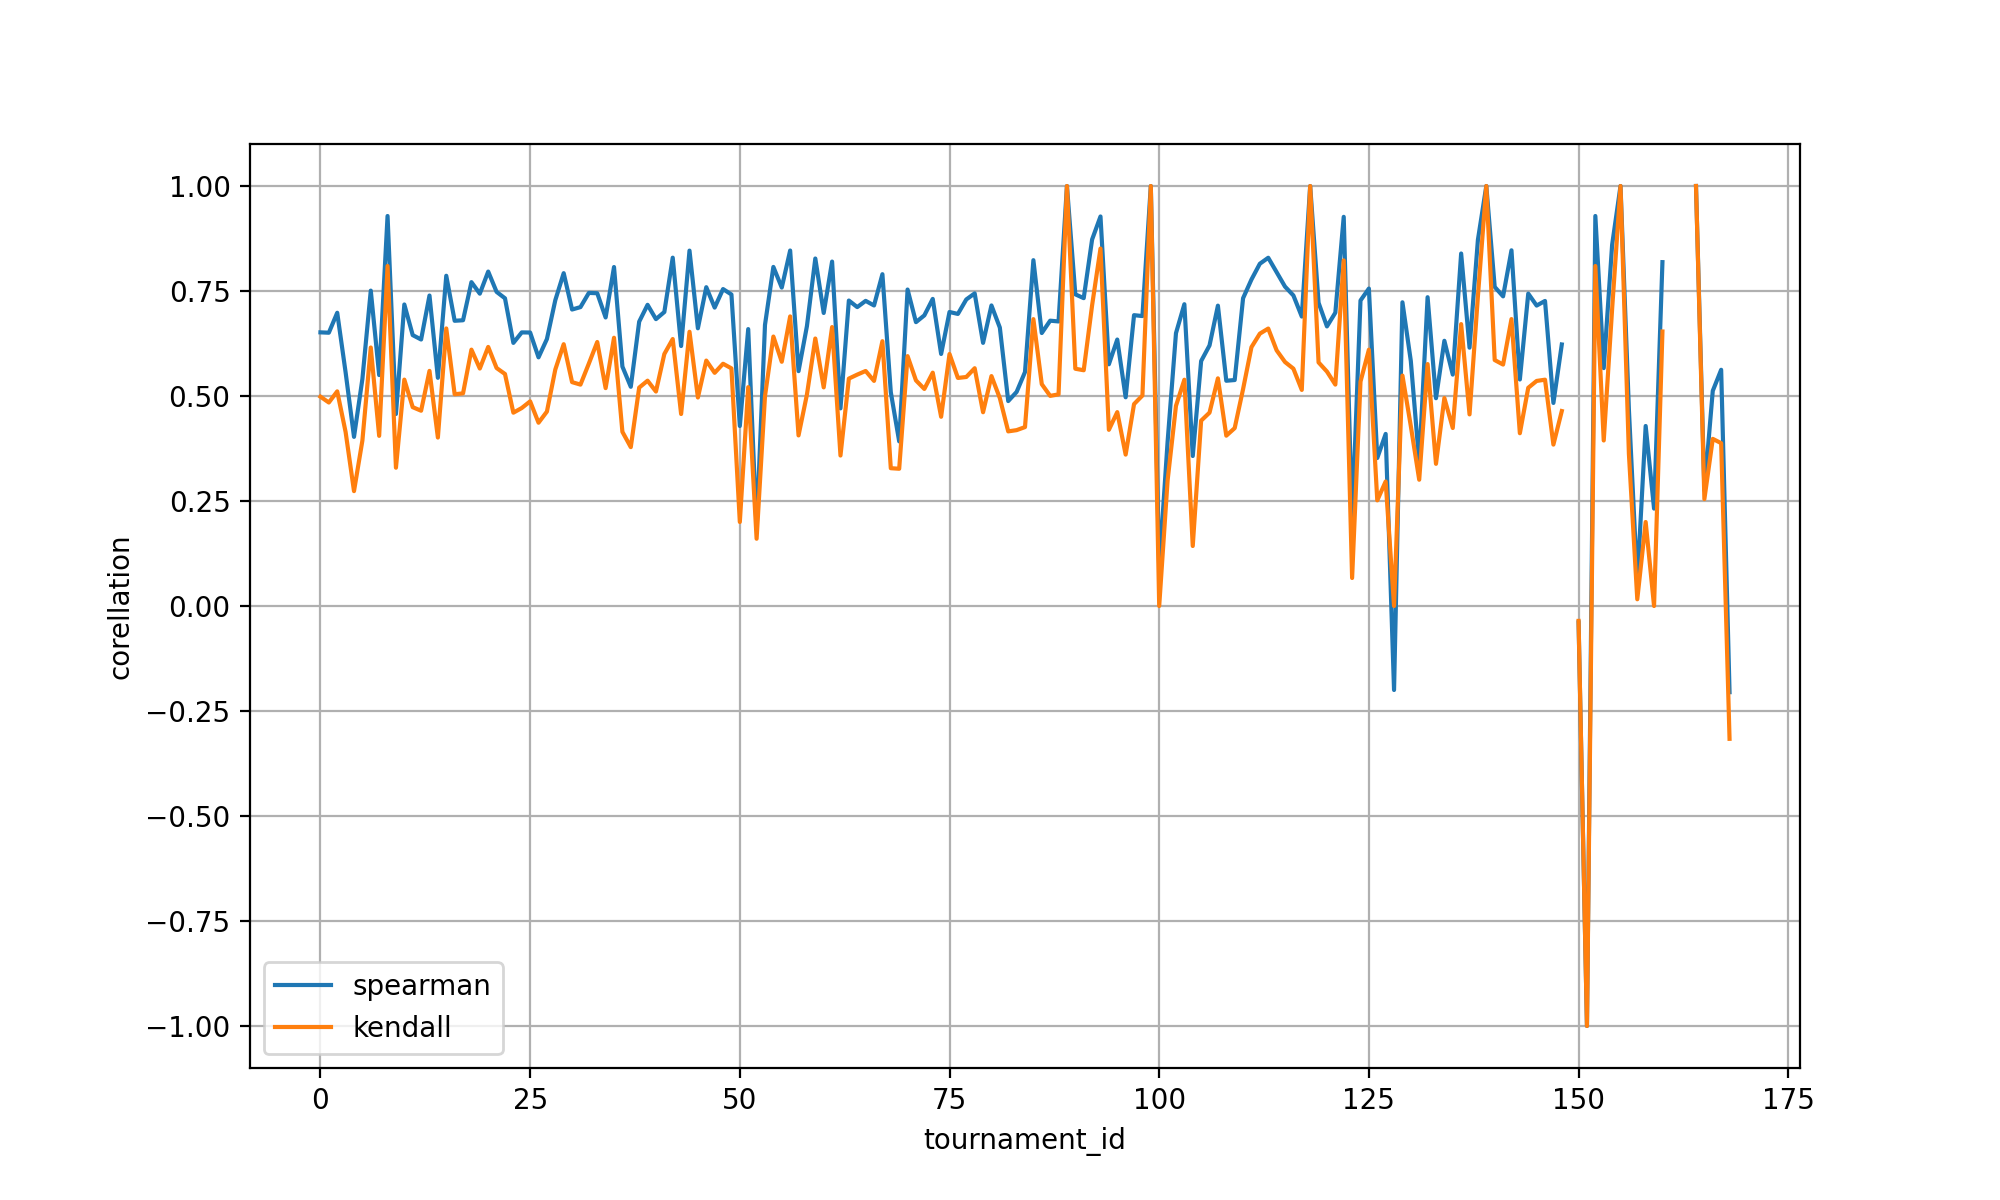

spearman corellation is 0.642
kendall corellation is 0.497


In [14]:
fig = plt.figure(figsize=(10, 6))

for data, label in zip((spearman, kendall), ('spearman', 'kendall')):
    plt.plot(data, label=label)
    print('%s corellation is %.3f' % (label, np.nanmean(data)))

plt.xlabel('tournament_id')
plt.ylabel('corellation')
plt.grid(True)
plt.legend();

### Expectation–Maximization 
##### 4.1 Предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков

В качестве скрытых переменных будем рассматривать $z = \mathbb{P}(player=1|team=1)$.

Таким образом, $\textbf{E шаг}$ строится из $$\mathbb{P}(player=1|team=1) = \frac{\mathbb{P}(team=1|player=1)\mathbb{P}(player=1)}{\mathbb{P}(team=1)} = \frac{\mathbb{P}(player=1)}{\mathbb{P}(team=1)}$$

$\textbf{M шаг}$ - максимизация правдоподобия.


<IPython.core.display.Javascript object>


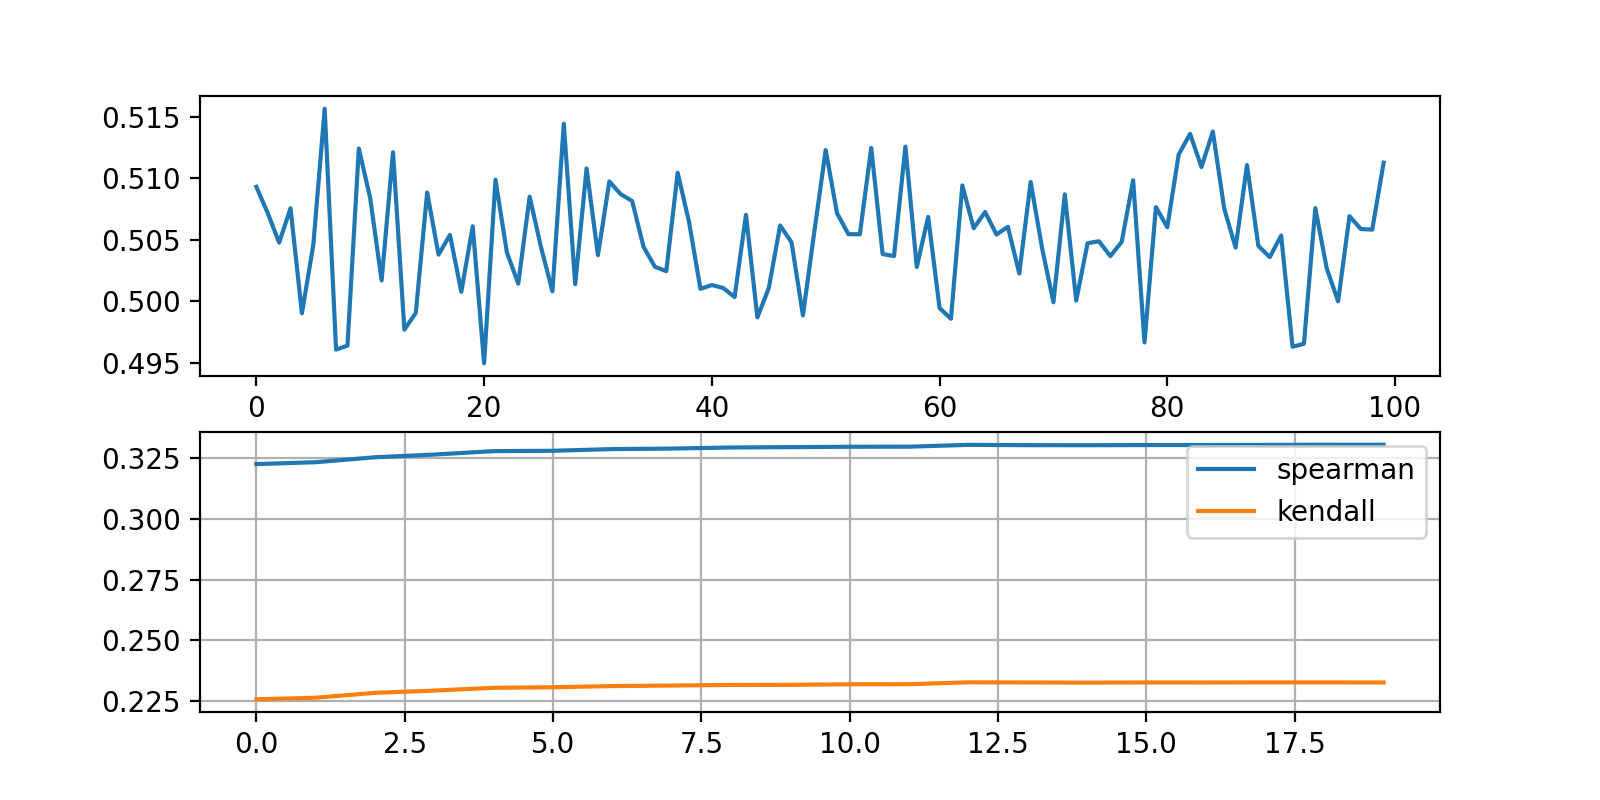

In [15]:
%matplotlib notebook
em_estimator = EM(
    dataset=train,
    X=X, y=y,
    player_to_idx=player_to_idx,
    epochs_em=2e1,
    epochs_pr=1e2,
)

em_estimator.fit(test_on=test)

<IPython.core.display.Javascript object>


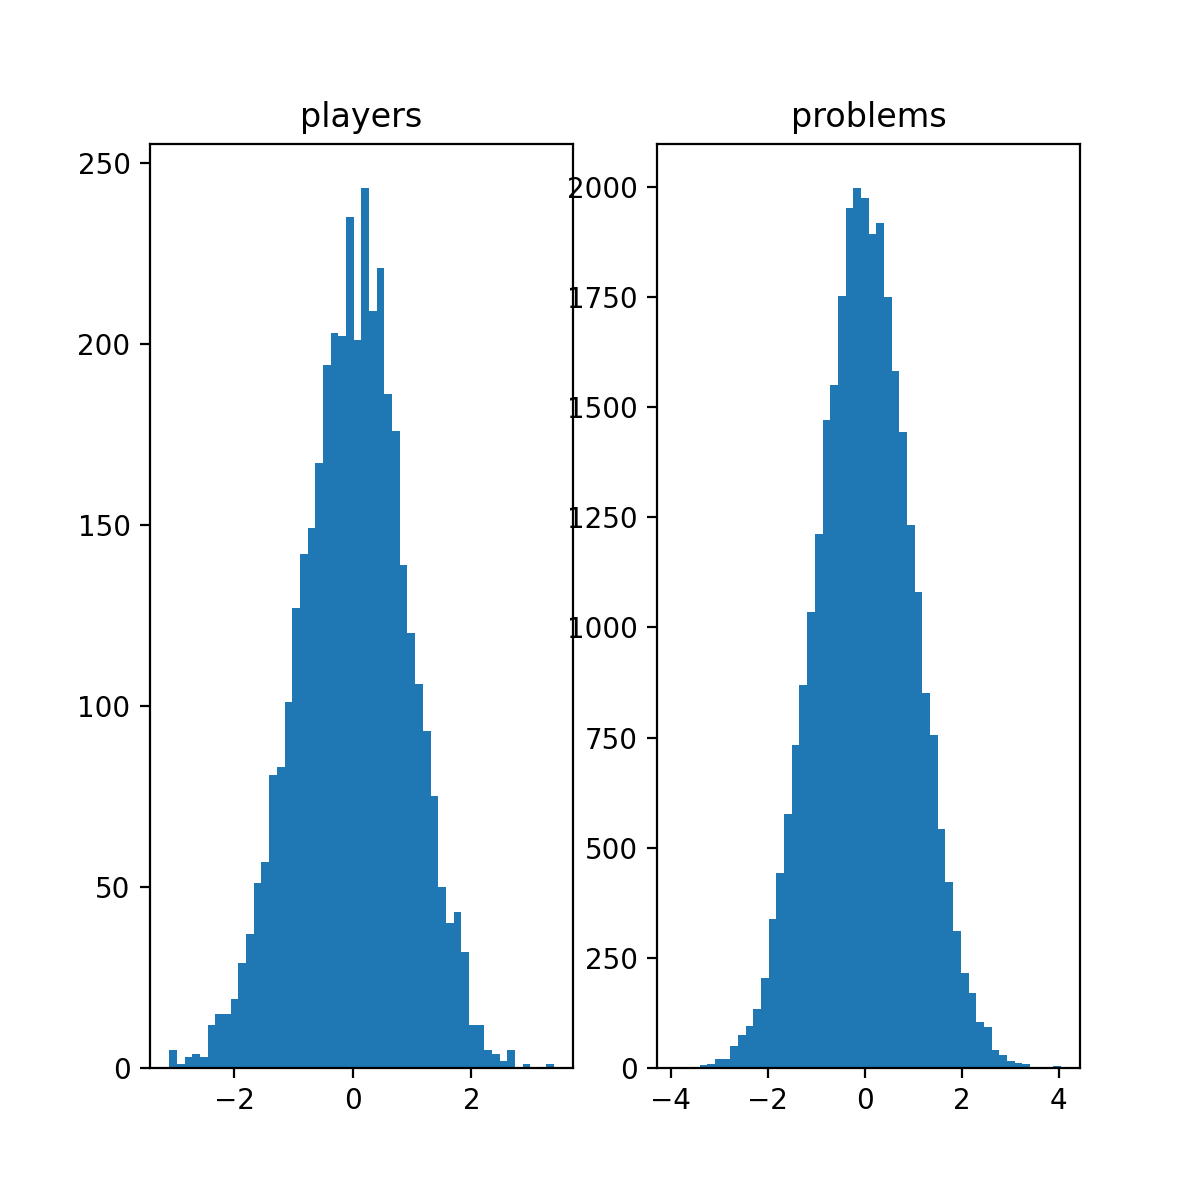

In [16]:
players_ranking = em_estimator.pr.w[1: len(player_to_idx) + 1]
problem_ranking = em_estimator.pr.w[1 + len(player_to_idx):]

fig, axes1d = plt.subplots(1, 2, figsize=(6, 6))

for i, (ranking, ranking_name) in enumerate(zip(
    (players_ranking, problem_ranking),
    ('players', 'problems'))):
    axes1d[i].hist(ranking, bins=50);
    axes1d[i].set_title(ranking_name);

Cудя по измененным графикам, дисперсия весов уменьшилась.

##### 5.1 А что там с вопросами? Постройте “рейтинг-лист” турниров по сложности вопросов.
Теперь для каждого вопроса мы знаем его силу, чем ниже вес вопроса, тем он труднее.

In [17]:
qv_rating = question_rating_calc(tour_name, problem_ranking, train)

Топ самых сложных турниров

In [18]:
qv_rating.head(20)

,id,name
0,5407,Девятый круг
1,6131,ДР Земцовского
2,5540,Регулярный чемпионат МГУ. Высшая лига. Третий ...
3,5466,Синхрон студенческого фестиваля Этажи
4,5531,Седьмая октава: Кубок Равноденствия. Лига Наци...
5,5881,Still Got the Blues
6,5946,Чемпионат Мира. Этап 3. Группа В
7,5641,Экватор
8,5834,Полжизни в ЧГК
9,5790,Белые ночи. The Best


Топ самых простых турниров

In [19]:
qv_rating.tail(20)

,id,name
643,5381,Пятая октава: Тропик Козерога. Лига Наций: Бел...
644,5312,Парный асинхронный турнир ChGK is...
645,5636,Кубок Закарпатья
646,5577,Чемпионат Минска. Лига А. Тур пятый
647,5597,Смоленская крепость
648,5604,Золотые огни: часть 1
649,5492,Кубок соседней галактики. Дельта
650,5630,Чемпионат МГУ. Открытая лига. Четвёртый игрово...
651,5397,Фламандский гамбит
652,5128,Лига Сибири. IV тур.
